In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_wine




# Dataset


In [2]:
data = load_wine()
df = pd.DataFrame(data.data, columns=data.feature_names)
df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


## Correlation

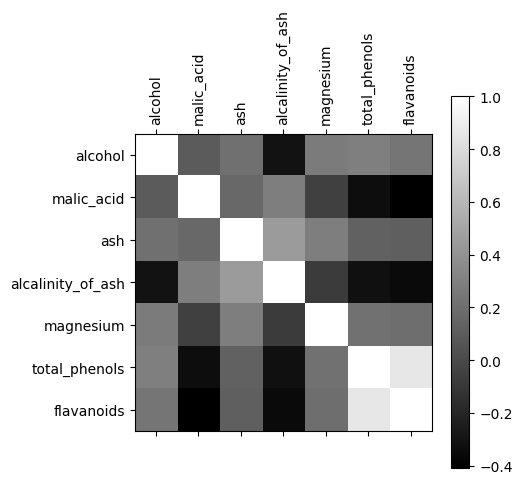

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids
alcohol,1.000000,0.094397,0.211545,-0.310235,0.270798,0.289101,0.236815
malic_acid,0.094397,1.000000,0.164045,0.288500,-0.054575,-0.335167,-0.411007
ash,0.211545,0.164045,1.000000,0.443367,0.286587,0.128980,0.115077
alcalinity_of_ash,-0.310235,0.288500,0.443367,1.000000,-0.083333,-0.321113,-0.351370
magnesium,0.270798,-0.054575,0.286587,-0.083333,1.000000,0.214401,0.195784
total_phenols,0.289101,-0.335167,0.128980,-0.321113,0.214401,1.000000,0.864564
flavanoids,0.236815,-0.411007,0.115077,-0.351370,0.195784,0.864564,1.000000


In [3]:
names = df.columns[:7]
corr_mtx = (df[names]).corr(method='pearson')
plt.matshow(corr_mtx, cmap="grey")
plt.colorbar()

plt.xticks(range(len(names)), names, rotation=90)
plt.yticks(range(len(names)), names)
plt.show()

corr_mtx

## Data Split


(124, 13)
(54, 13)
(124,)
(54,)


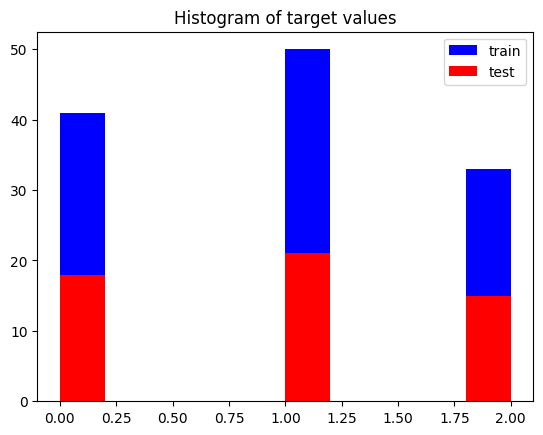

In [4]:
from sklearn.model_selection import train_test_split
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

plt.hist(y_train, color='blue', label='train')
plt.hist(y_test, color='red', label='test')
plt.title('Histogram of target values')
plt.legend()
plt.show()

# Training - without Optuna


## Metric function

In [146]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    accuracy_score,
    precision_score,  # Dodano Precision
    recall_score      # Dodano Recall dla ułatwienia
)
from sklearn.preprocessing import label_binarize
from itertools import cycle

def metrics_multiclass(y_true: np.ndarray, y_pred_classes: np.ndarray, y_pred_scores: np.ndarray, method: str) -> pd.DataFrame:
    """
    Calculates and plots classification metrics (Accuracy, Precision, Recall, Specificity, AUC)
    for multiclass classification, displaying results in a Pandas DataFrame table.

    Args:
        y_true (np.ndarray): True labels (ground truth).
        y_pred_classes (np.ndarray): Predicted class labels.
        y_pred_scores (np.ndarray): Predicted probabilities (or decision scores) for each class.
                                     Shape should be (n_samples, n_classes).
        method (str): Name of the classification method (for plot title).

    Returns:
        pd.DataFrame: A DataFrame containing the combined per-class and macro-averaged metrics.
    """

    classes = np.unique(y_true)
    n_classes = len(classes)

    # ----------------------------------------------------
    # 1. Obliczenia
    # ----------------------------------------------------

    accuracy = accuracy_score(y_true, y_pred_classes)
    cf_mtx = confusion_matrix(y_true, y_pred_classes)

    # Scikit-learn calculation (easier and more robust)
    recall_per_class = recall_score(y_true, y_pred_classes, average=None, zero_division=0)
    precision_per_class = precision_score(y_true, y_pred_classes, average=None, zero_division=0)

    # Ręczne obliczenie Specyficzności (One-vs-Rest)
    specificity_per_class = []
    for i in range(n_classes):
        TP = cf_mtx[i, i]
        FN = np.sum(cf_mtx[i, :]) - TP
        FP = np.sum(cf_mtx[:, i]) - TP
        TN = np.sum(cf_mtx) - (TP + FN + FP)

        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        specificity_per_class.append(specificity)

    # Obliczenie AUC (One-vs-Rest)
    y_true_bin = label_binarize(y_true, classes=classes)
    roc_auc_per_class = []

    # Collect AUC for plotting and report
    for i in range(n_classes):
        roc_auc_class = roc_auc_score(y_true_bin[:, i], y_pred_scores[:, i])
        roc_auc_per_class.append(roc_auc_class)

    roc_area_macro = roc_auc_score(y_true_bin, y_pred_scores, multi_class='ovr', average='macro')

    # ----------------------------------------------------
    # 2. Tworzenie DataFrame z Metrykami
    # ----------------------------------------------------

    # Metryki dla każdej klasy
    df_per_class = pd.DataFrame({
        'Klasa': classes,
        'Czułość (Recall)': recall_per_class,
        'Precyzja (Precision)': precision_per_class,
        'Specyficzność': specificity_per_class,
        'AUC (OvR)': roc_auc_per_class
    })

    # Metryki Uśrednione
    macro_row = pd.DataFrame({
        'Klasa': ['Macro-Avg', 'Accuracy (overall)'],
        'Czułość (Recall)': [np.mean(recall_per_class), np.nan],
        'Precyzja (Precision)': [np.mean(precision_per_class), np.nan],
        'Specyficzność': [np.mean(specificity_per_class), np.nan],
        'AUC (OvR)': [roc_area_macro, np.nan]
    })

    # Metryka Ogólna (Accuracy)
    accuracy_row = pd.DataFrame({
        'Klasa': ['Accuracy (overall)'],
        'Czułość (Recall)': [np.nan],
        'Precyzja (Precision)': [np.nan],
        'Specyficzność': [np.nan],
        'AUC (OvR)': [np.nan]
    })

    # Łączenie i dodanie Accuracy w osobnym wierszu
    df_metrics = pd.concat([df_per_class, macro_row]).reset_index(drop=True)
    df_metrics.loc[df_metrics['Klasa'] == 'Accuracy (overall)', 'Czułość (Recall)'] = accuracy # Używamy dowolnej komórki 'Overall' do wstawienia Accuracy
    df_metrics.loc[df_metrics['Klasa'] == 'Accuracy (overall)', 'Precyzja (Precision)'] = accuracy
    df_metrics.loc[df_metrics['Klasa'] == 'Accuracy (overall)', 'Specyficzność'] = accuracy
    df_metrics.loc[df_metrics['Klasa'] == 'Accuracy (overall)', 'AUC (OvR)'] = accuracy
    df_metrics.rename(columns={'Czułość (Recall)': 'Recall',
                               'Precyzja (Precision)': 'Precision',
                               'Specyficzność': 'Specifity',
                               'AUC (OvR)': 'AUC_score'}, inplace=True)

    # Wyróżnienie wierszy
    # Wyczyszczenie NaN
    df_metrics = df_metrics.fillna('')

    # ----------------------------------------------------
    # 3. Plotting
    # ----------------------------------------------------

    # Używamy większego figsize
    fig, ( ax_matrix, ax_roc) = plt.subplots(1, 2, figsize=(22, 6))

    # 1. Confusion Matrix Display
    cf_mtx_disp = ConfusionMatrixDisplay(confusion_matrix=cf_mtx, display_labels=classes)
    cf_mtx_disp.plot(ax=ax_matrix, cmap='grey', values_format='d')
    ax_matrix.set_title("Macierz Pomyłek", fontsize=14)

    # 3. ROC Curve Display (Plotting OvR for each class)
    ax_roc.set_title(f'Krzywe ROC (One-vs-Rest)\nMacro AUC: {roc_area_macro:.4f}', fontsize=14)
    ax_roc.plot([0, 1], [0, 1], 'k--', label='Losowy (AUC = 0.5)', alpha=0.6) # Diagonal line

    # Calculate and plot ROC for each class
    colors = cycle(['blue', 'red', 'green', 'purple', 'orange']) # Dodałem więcej kolorów na wszelki wypadek
    for i, color in zip(range(n_classes), colors):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_scores[:, i])

        ax_roc.plot(
            fpr,
            tpr,
            linewidth=2,
            label=f'Klasa {classes[i]} (AUC: {roc_auc_per_class[i]:.2f})',
            color=color,
            alpha=0.7
        )

    ax_roc.set_xlabel('Odsetek Fałszywie Pozytywnych (FPR)')
    ax_roc.set_ylabel('Czułość (TPR)')
    ax_roc.legend(loc="lower right", fontsize=9)
    ax_roc.grid(linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

    # Zwrócenie skonsolidowanego DataFrame
    return df_metrics



model_performence = {}

## Logistic Regression

In [147]:
from sklearn.linear_model import LogisticRegression
logic_base_model = LogisticRegression(max_iter=5000)
logic_base_model.fit(X_train, y_train, sample_weight=None)



LogisticRegression(max_iter=5000)

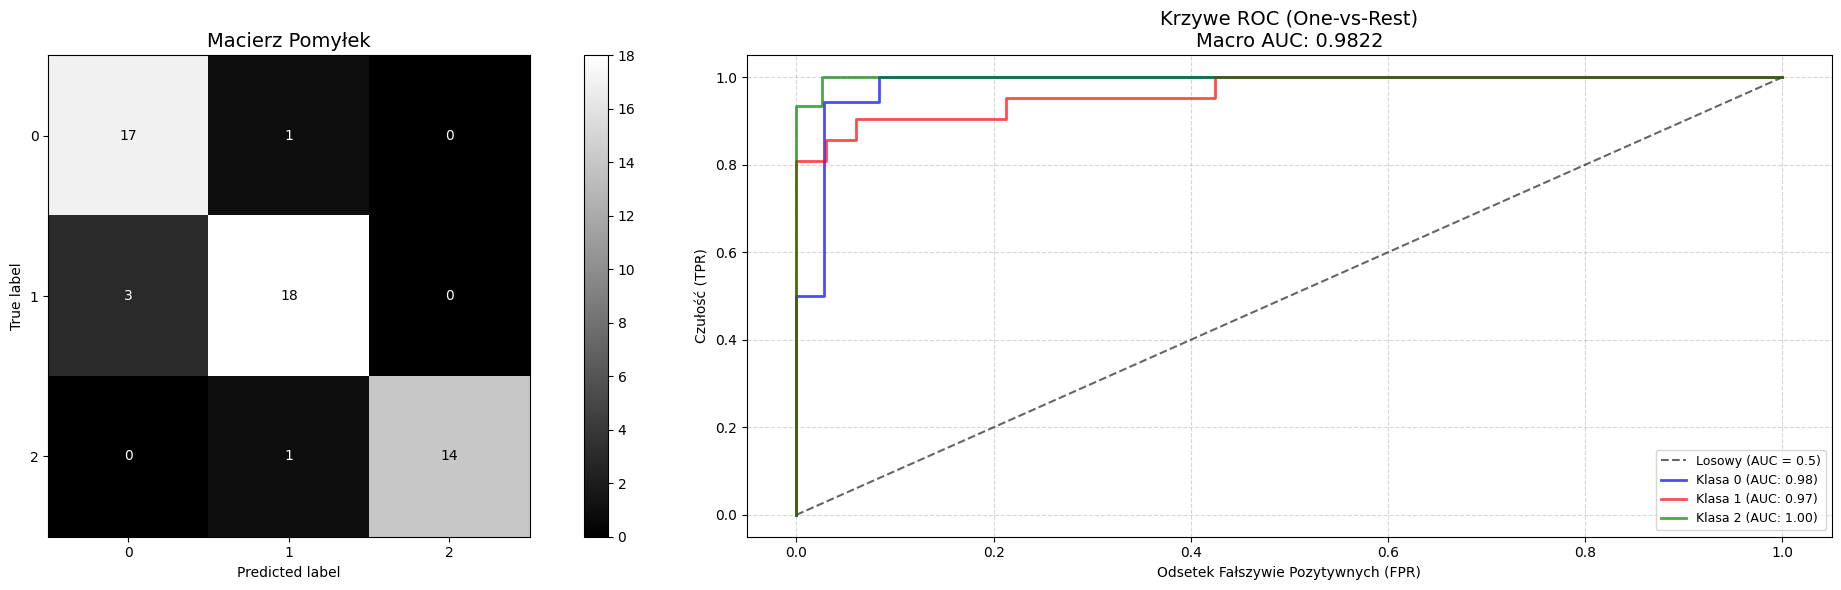

,Klasa,Recall,Precision,Specifity,AUC_score
0,0,0.944444,0.850000,0.916667,0.983025
1,1,0.857143,0.900000,0.939394,0.965368
2,2,0.933333,1.000000,1.000000,0.998291
3,Macro-Avg,0.911640,0.916667,0.952020,0.982228
4,Accuracy (overall),0.907407,0.907407,0.907407,0.907407


In [148]:
y_pred =logic_base_model.predict(X_test)
y_scores = logic_base_model.predict_proba(X_test)
model_performence['Logistic Base'] = metrics_multiclass(y_test, y_pred, y_scores, 'logistic base')
model_performence['Logistic Base']

## KNN

In [46]:
from sklearn.neighbors import KNeighborsClassifier
knn_base = KNeighborsClassifier()
knn_base.fit(X_train, y_train) #No sample_weight

KNeighborsClassifier()

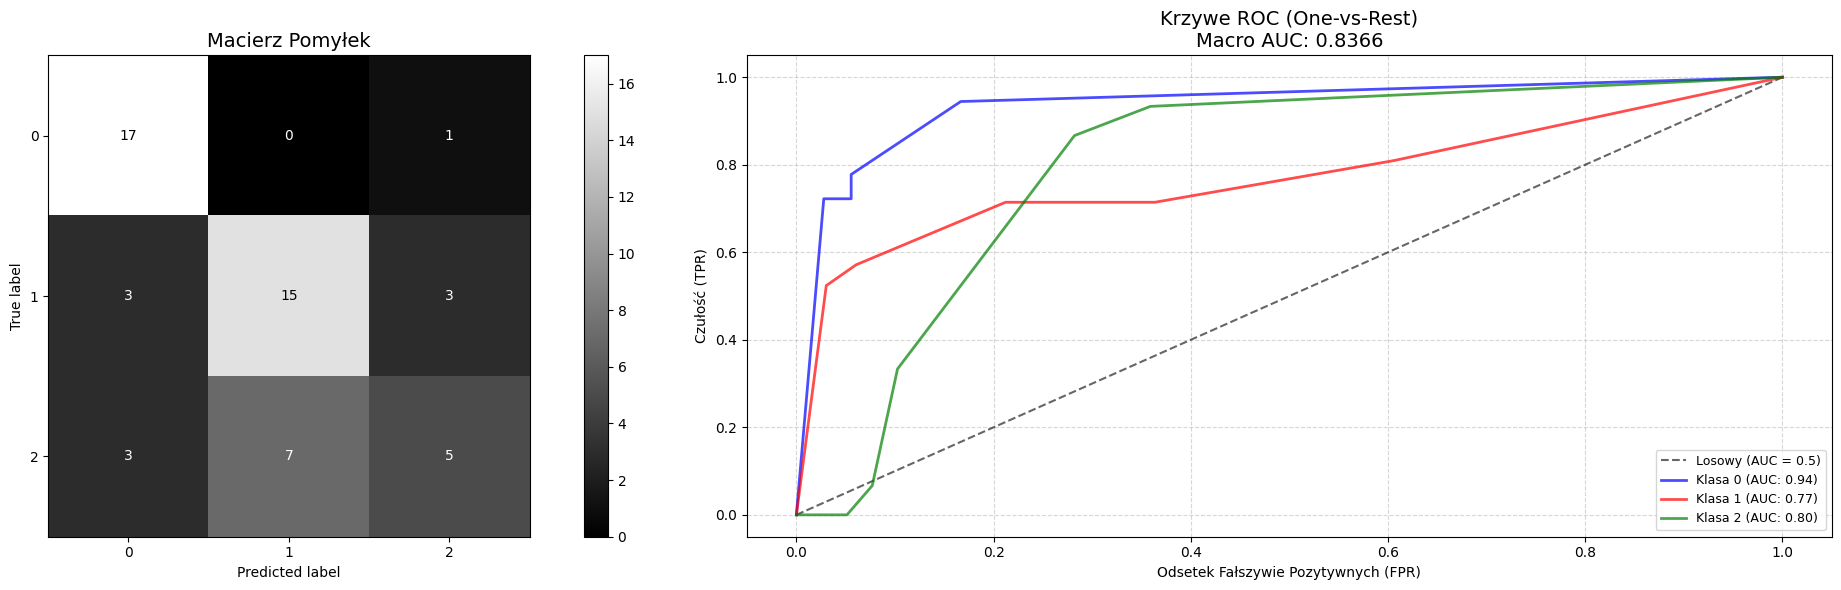

,Klasa,Recall,Precision,Specifity,AUC_score
0,0,0.944444,0.739130,0.833333,0.935957
1,1,0.714286,0.681818,0.787879,0.771284
2,2,0.333333,0.555556,0.897436,0.802564
3,Macro-Avg,0.664021,0.658835,0.839549,0.836602
4,Accuracy (overall),0.685185,0.685185,0.685185,0.685185


In [149]:
y_pred =knn_base.predict(X_test)
y_scores = knn_base.predict_proba(X_test)
model_performence['KNN Base'] = metrics_multiclass(y_test, y_pred, y_scores, 'KNN base')
model_performence['KNN Base']

## LDA

In [49]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda_base = LinearDiscriminantAnalysis()
lda_base.fit(X_train, y_train) #no sample weights

LinearDiscriminantAnalysis()

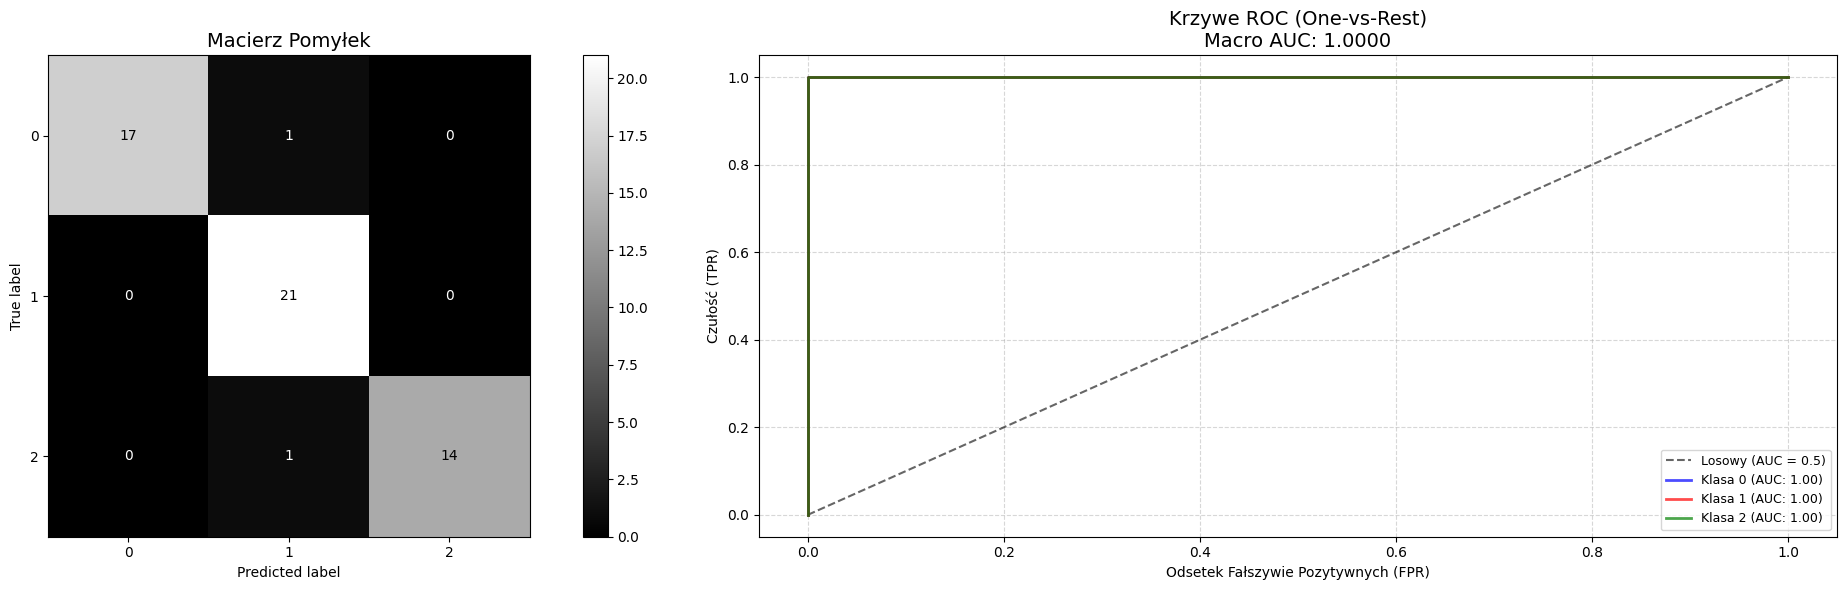

,Klasa,Recall,Precision,Specifity,AUC_score
0,0,0.944444,1.000000,1.000000,1.000000
1,1,1.000000,0.913043,0.939394,1.000000
2,2,0.933333,1.000000,1.000000,1.000000
3,Macro-Avg,0.959259,0.971014,0.979798,1.000000
4,Accuracy (overall),0.962963,0.962963,0.962963,0.962963


In [150]:
y_pred = lda_base.predict(X_test)
y_scores = lda_base.predict_proba(X_test)
model_performence['LDA Base'] = metrics_multiclass(y_test, y_pred, y_scores, 'LDA base')
model_performence['LDA Base']

# Hyperparameters Optuna

In [ ]:
import optuna
